# Preparation

In [3]:
#library to read and import file from drive
import os
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#images
import cv2 as cv
import matplotlib.pyplot as plt
#import seaborn_image as isns

#### Paths

In [4]:
path_data = '../Data/DatasetGP5Bicocca'

#### Functions

In [5]:
# Function to crop image 
def crop(img, mask=False):
    #gaussian filter
    tmp = cv.GaussianBlur(img,(21,21),0)

    ret1, th1 = cv.threshold(tmp, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    ret2, th2 = cv.threshold(img, 120, 255, cv.THRESH_BINARY)

    x, y, w, h = cv.boundingRect(th1)

    if(w<h):
        diff = h-w
        y = y+(diff//2)
        h = h-diff
    #return input image with crop and in b&w
    border = 50
    if(mask):
        return th2[y-border:y+h+border, x-border:x+w+border]
    return img[y-border:y+h+border, x-border:x+w+border]

In [6]:
# Function to scale pixel values from 0..255 to 0..1
def scale_pixels(img, scale_range=(0, 1)):
    return img.astype('float32') / 255.

In [7]:
# Function to resize images
def resize(img, size=(1024, 1024)):
    return cv.resize(img, size)

In [8]:
# Function to divide images into smaller parts
def split_patches(img, n_patches=16):
    imgs_list = []
    dim = int(img.shape[0]//(16**(1/2)))
    for i in range(0, n_patches):
        x = int(dim*(i%(16**(1/2))))
        y = int(dim*(i//(16**(1/2))))
        imgs_list.append(img[y:y+dim, x:x+dim])
    return imgs_list

In [9]:
# Function to apply a set of preprocessing functions and saving them divided in train and test sets
def preprocess(source_path, dest_path, functions=[], format='.jpg', test_size=0, seed=0):
    #creazione cartelle
    os.mkdir('../Data/Prepared/Train')
    os.mkdir('../Data/Prepared/Train/OK')
    os.mkdir('../Data/Prepared/Train/NOK')
    os.mkdir('../Data/Prepared/Test')
    os.mkdir('../Data/Prepared/Test/OK')
    os.mkdir('../Data/Prepared/Test/NOK')
    
    for folder in os.listdir(source_path):
        list_imgs = os.listdir(source_path + '/' + folder)
        train_imgs, test_imgs = train_test_split(list_imgs, test_size=test_size, random_state=seed) 
        i=0
        for img_name in train_imgs:
            img = cv.imread(source_path + '/' + folder + '/' + img_name, cv.IMREAD_GRAYSCALE)
            for func in functions:
                img = func(img) 
            j=0
            for slice in img:
                new_path = dest_path + '/Train/' + folder + '/' + folder + '_' + str(i) + '-' + str(j) + format
                cv.imwrite(new_path, slice)
                j=j+1
            i=i+1
        i=0
        for img_name in test_imgs:
            img = cv.imread(source_path + '/' + folder + '/' + img_name, cv.IMREAD_GRAYSCALE)
            for func in functions:
                img = func(img) 
            j=0
            for slice in img:
                new_path = dest_path + '/Test/' + folder + '/' + folder + '_' + str(i) + '-' + str(j) + format
                cv.imwrite(new_path, slice)
                j=j+1
            i=i+1

## Dataset extraction

In [10]:
zipf = zipfile.ZipFile('../Data/Original.zip')
zipf.extractall("../Data")
zipf.close()

## Data exploration and visualization

#### Number of images for each class

In [11]:
list_NOK = os.listdir(path_data + '/NOK')
list_OK = os.listdir(path_data + '/OK')
number_NOK = len(list_NOK)
number_OK = len(list_OK)
print("The number of NO ok images is:", number_NOK)
print("The number of ok images is:", number_OK)

The number of NO ok images is: 19
The number of ok images is: 104


#### Example of OK and NOK images

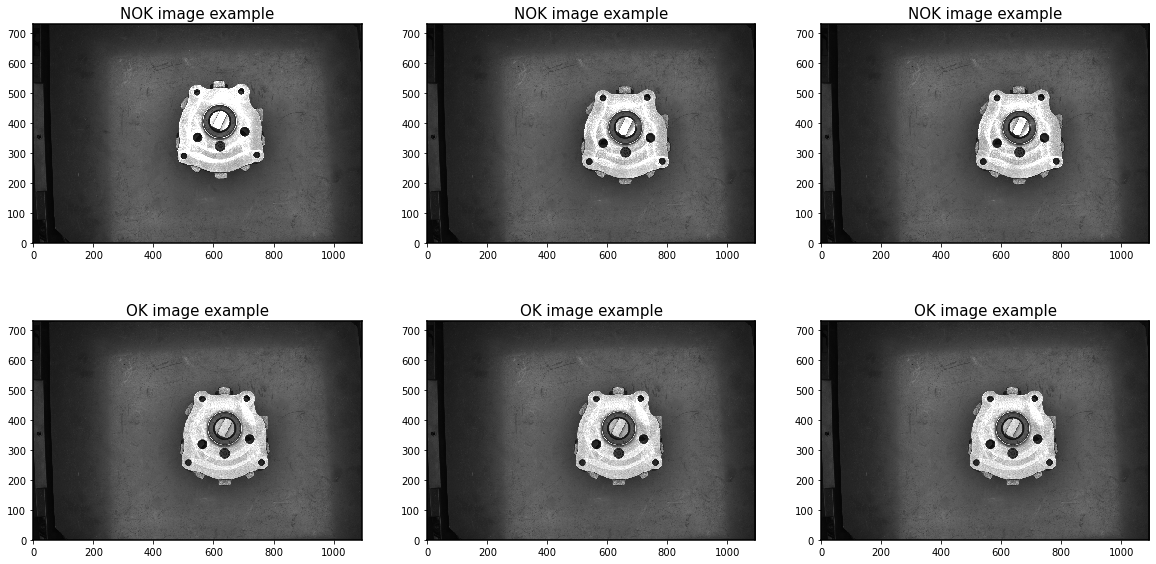

In [26]:
# Plotting the first 3 images for the classes OK and NOK
plt.figure(figsize=(20,10))
i=1
for folder in os.listdir(path_data):
    for img, j in zip(os.listdir(path_data + '/' + folder), range(0, 3)):
        example = cv.imread(path_data + '/' + folder + '/' + img)
        example = cv.resize(example, (None), fx=0.2, fy=0.2)
        plt.subplot(2,3,i)
        plt.title(folder +  ' image example')
        plt.imshow(example)
        i=i+1

Da queste immagini si può notare come la caratteristica principale delle immagini NOK è quella di presentare delle piccole macchie nere sulla superficie del pezzo (dovuto alla mancanza di materiale).
Si osserva che le dimensioni dei difetti sono molto ridotte e questo fatto dovrà essere tenuto in considerazione nella fase di selezione del modello.

### Histogram images comparison

Text(0.5, 1.0, 'Defective piece')

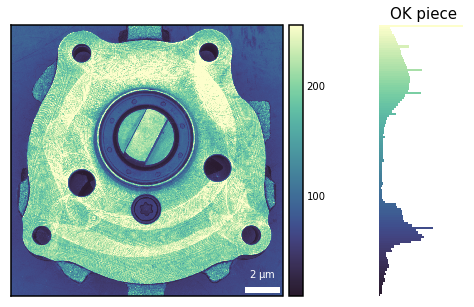

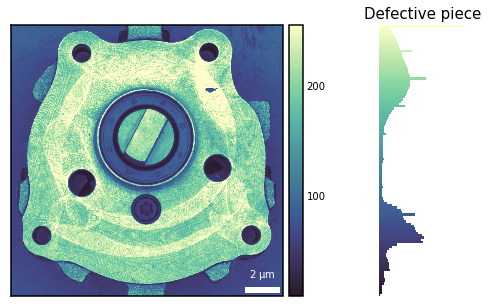

In [32]:
example_ok = cv.imread(path_data + '/OK/OK (2).bmp', cv.IMREAD_GRAYSCALE)
example_nok = cv.imread(path_data + '/NOK/NOK (7).bmp', cv.IMREAD_GRAYSCALE)

example_crop_ok = crop(example_ok)
example_crop_nok = crop(example_nok)

isns.imghist(example_crop_ok, dx=0.01, units="um")
plt.title('OK piece')

isns.imghist(example_crop_nok, dx=0.01, units="um")
plt.title('Defective piece')

Non si riscontrano varianze significative negli istogrammi per via della dimensione ridotta dei difetti

## Cleaning

#### Crop production piece from image

Text(0.5, 1.0, 'Threshold mask')

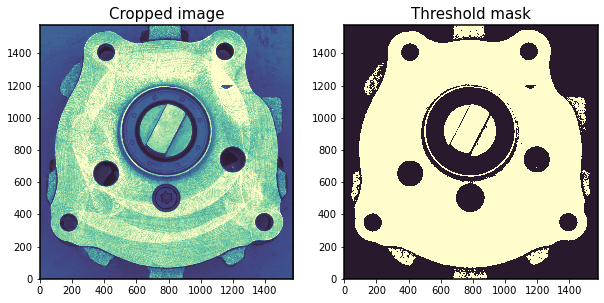

In [34]:
#example of crop function
example_nok = cv.imread(path_data + '/NOK/NOK (7).bmp', cv.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(crop(example_nok))
plt.title('Cropped image')

plt.subplot(1, 2, 2)
plt.imshow(crop(example_nok, True))
plt.title('Threshold mask')


## Save prepared dataset

In [12]:
preprocess(path_data, dest_path='../Data/Prepared', functions=[crop, resize, split_patches], format='.jpg', test_size=0.2, seed=17)